# CoreML (Artist recommendation)

### Table of contents

- <a href='#setup'>Setup</a>
- <a href='#metric'>Metric</a>
- <a href='#preprocessing'>Data Preprocessing</a>
- <a href='#training_data'>Training Data Generating</a>
- <a href='#model'>Model (initialization & train)</a>
- <a href='#model_interpretation'>Model Interpretation</a>
- <a href='#indexing'>Indexing</a>
- <a href='#recommendation'>Recommendation</a>
- <a href='#metric_eval'>Metric Evaluation</a>
- <a href='#conclusion'>Conclusion</a>

### Задача
Передо мной была поставлена задача научиться искать похожих музыкальных исполнителей. В терминах машинного обучения это означает, что для каждого исполнителя нужно построить векторное представление таким образом, чтобы похожие исполнители оказались близко в векторном пространстве, тогда задача поиска похожих исполнителей сведётся к задаче поиска ближайших соседей.

Оценивать качество полученных векторных представлений будем на задаче *Artist Recommendation* — рекомендация исполнителя для пользователя.


### Как решалось ?

#### Метрика
В качестве метрики будем использовать следующее. Разобьем сессию треков на две части: первую, по котрой будем предсказывать новых авторов и вторую, по которой будем сверять количество совпавших авторов. Результатом будем считать число: $\frac{количество-совпавших-авторов}{количество-рекомендованных-авторов}$. Эту метрику можно считать accuracy-подобной.

При такой оценке метрики мы немного отходим от задачи рекомендации исполнителя для пользователя, и рекомендуем исполнителя для плейлиста, однако у пользователей можно собирать их плейлисты и на их основе выдавать рекомендации. Но для оценки качества было решено, что проще работать с плейлистами, а не с пользователями.


#### Методы

Главным способом построения векторных представлений для артистов будем использовать **CBOW/skip-gram**. То есть будем по контексту авторов угадывать еще одного автора. При решении такой задачи нейронная сеть будет иметь внутри себя таблицу весов, которая по своей сути и будет давать нам векторные представления для артистов.

Векторы являются 128-размерными.

#### Обучение

Для обучения были взяты сессии прослушиваний, у которых количество прослушанных композиций не меньше 4. После чего разбиты на тренировочные данные, оставив только тех авторов, кто входил в топ-2000 самых публикующих (наибольшее количество треков). Это позволяет оставить в датасете треков наибольшее количество примеров и при этом задать словарь для модели из 2000 элементов, что хорошо при использовании малого количества оперативной памяти.

#### Качество методов

Качество векторного представления было оценено как визуально, так и измерив метрику, которая дала резльтат в *0.016*. Замер метрики производился на данных из датасета `playlists`, который модель прежде не видела.


<a id='setup'></a>

## Setup
В `Setup.ipynb` содержатся различные import'ы, которые захламляют основной файл, поэтому они вынесены. Также там содержатся полезные функции, которые делают разработку внутри данного файла более удобной и быстрой.

In [83]:
run Setup.ipynb

Imports done!


<a id='metric'></a>

## Metric

Запишем функцию, которая будет вычислять качество наших рекомендаций, т.е. метрику

In [191]:
def metric(playlist, index, embeddings, k=5):
    try:
        train_artists, test_artists = train_test_split(playlist, train_size=0.4)

        suggested = np.array([])
        for artist in train_artists:
            D, I = index.search(embeddings[[artist], :], k+1)
            ids = I[0][1:]

            suggested = np.concatenate([suggested, ids])
        suggested = list(map(lambda x: x[0], Counter(suggested).most_common(k)))
        summ = sum([int(s) in test_artists for s in suggested])

        return summ / k or 0
    
    except ValueError:
        return 0

<a id='preprocessing'></a>

## Data Preprocessing

Вся предварительная обработка данных ведется в файле `Preprocessing.ipynb`. На данный момент данные предобработаны, но при наличие новых идей по обработке данных, а также при отсутствии исходных данных следует запустить следующий код:

`run Preprocessing.ipynb`

In [3]:
with open('data/track_to_artist.pickle', 'rb') as f:
    track_to_artist = pickle.load(f)

In [4]:
persons_df = pd.read_csv('data/persons.csv', index_col=0)

persons_df.head()

,artist_id,MBID,artist_name
99,109097,4279aba0-1bde-40a9-8fb2-c63d165dc554,Delerium
178,66552,NaN,Camille+Saint-Saëns
260,396749,NaN,W+&+Whale
329,229444,NaN,M.+Jackson+&+Minnie+Ripperton
367,26802,NaN,Antonio+Carlos+Jobim+&+Vinicius+De+Moraes


In [5]:
tracks_df = pd.read_csv('data/tracks.csv', index_col=0)

tracks_df.head()

,track_id,playcount,MBID,artist
4,2247780,35.0,3b3faa59-e657-4127-b886-d344d0655b67,31464
7,1611689,124.0,70f2a497-98f3-468d-a749-1d761161338b,202442
13,1231115,304.0,NaN,48929
17,3583293,139.0,NaN,447579
20,4933896,0.0,NaN,175645


In [6]:
sessions_df = pd.read_csv('data/sessions.csv', index_col=0)
sessions_df = sessions_df.sample(frac=1.0)
for column in sessions_df.columns[:3]:
    sessions_df[column] = sessions_df[column].apply(json.loads)
    
sessions_df.head()

,tracks_ids,play_ratios,artists_ids,user,numtracks,playtime
2276205,"[440094, 440870, 440094, 1175085, 234832, 1569...","[0.25, 0.31, 0.24, 0.66, 1.02, 1.0, 0.24, 1.02...","[53169, 53169, 53169, 149679, 29575, 197007, 1...",34397.0,29.0,5801.0
271697,"[4472052, 4472053, 4472054, 4472055, 4472056, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[32845, 516728, 516673, 464651, 183272, 516727...",42258.0,7.0,1174.0
1535535,"[88747, 1654424, 280988, 3352710, 1539952, 237...","[0.69, 1.01, 1.01, 1.07, 1.01, 1.0, 1.03, 1.0,...","[12141, 208145, 34930, 416320, 192908, 296331,...",44236.0,22.0,4415.0
953127,"[2572652, 2572654, 2572653, 2572657, 2572656]","[0.76, 0.99, 1.38, 1.28, 1.0]","[322745, 322745, 322745, 322745, 322745]",29514.0,5.0,1578.0
2380101,"[2035490, 3035337, 3590890, 3300329, 3739026, ...","[1.0, 1.0, 1.0, 1.24, 1.0, 1.12, 0.67, 1.0, 1....","[254745, 374349, 448656, 408323, 447098, 11461...",20401.0,14.0,3580.0


In [72]:
sessions_df['user'].nunique()

43882

In [73]:
sessions_df['user'].shape

(1544641,)

Далее мы закодируем `id` авторов, чтобы нумерация начиналась с 0 и мы могли бы легко представить автора как вектор, у которого 1 стоит на компоненте, номер которой равен `id`. Для этого воспользуемся LabelEnocder'ом.

In [7]:
artist_encoder = LabelEncoder()

tracks_df['artist'] = artist_encoder.fit_transform(tracks_df['artist'])
tracks_df.head()

,track_id,playcount,MBID,artist
4,2247780,35.0,3b3faa59-e657-4127-b886-d344d0655b67,157
7,1611689,124.0,70f2a497-98f3-468d-a749-1d761161338b,992
13,1231115,304.0,NaN,262
17,3583293,139.0,NaN,1919
20,4933896,0.0,NaN,873


In [8]:
def old_to_new_artist(old_artists):
    new_artists = []

    for artist in old_artists:
        new_artists.append(ae_dict.get(artist, len(artist_encoder.classes_)))
    
    return new_artists

ae_dict = dict(zip(artist_encoder.classes_, artist_encoder.transform(artist_encoder.classes_)))

In [9]:
sessions_df['new_artists_ids'] = sessions_df['artists_ids'].apply(old_to_new_artist)
sessions_df.head(10)

,tracks_ids,play_ratios,artists_ids,user,numtracks,playtime,new_artists_ids
2276205,"[440094, 440870, 440094, 1175085, 234832, 1569...","[0.25, 0.31, 0.24, 0.66, 1.02, 1.0, 0.24, 1.02...","[53169, 53169, 53169, 149679, 29575, 197007, 1...",34397.0,29.0,5801.0,"[288, 288, 288, 740, 145, 967, 1999, 1233, 164..."
271697,"[4472052, 4472053, 4472054, 4472055, 4472056, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[32845, 516728, 516673, 464651, 183272, 516727...",42258.0,7.0,1174.0,"[1999, 1999, 1999, 1999, 1999, 1999, 1999]"
1535535,"[88747, 1654424, 280988, 3352710, 1539952, 237...","[0.69, 1.01, 1.01, 1.07, 1.01, 1.0, 1.03, 1.0,...","[12141, 208145, 34930, 416320, 192908, 296331,...",44236.0,22.0,4415.0,"[51, 1999, 1999, 1999, 1999, 1999, 1999, 1999,..."
953127,"[2572652, 2572654, 2572653, 2572657, 2572656]","[0.76, 0.99, 1.38, 1.28, 1.0]","[322745, 322745, 322745, 322745, 322745]",29514.0,5.0,1578.0,"[1999, 1999, 1999, 1999, 1999]"
2380101,"[2035490, 3035337, 3590890, 3300329, 3739026, ...","[1.0, 1.0, 1.0, 1.24, 1.0, 1.12, 0.67, 1.0, 1....","[254745, 374349, 448656, 408323, 447098, 11461...",20401.0,14.0,3580.0,"[1999, 1683, 1922, 1801, 1914, 1999, 799, 1999..."


In [10]:
playlists_df = pd.read_csv('data/playlist.csv', index_col=0)
playlists_df['authors_ids'] = playlists_df['authors_ids'].apply(json.loads)
playlists_df['new_artists_ids'] = playlists_df['authors_ids'].apply(old_to_new_artist)

playlists_df.head()

,authors_ids,new_artists_ids
0,"[283322, 338265, 409167, 460940, 80485, 320708...","[1355, 1999, 1999, 1980, 454, 1500, 1501, 1999]"
1,"[202099, 202099, 216266, 216266, 344752, 34475...","[1999, 1999, 1999, 1999, 1999, 1999, 1999, 199..."
2,"[266376, 266376, 266376, 266376, 266376, 26637...","[1273, 1273, 1273, 1273, 1273, 1273, 1273, 199..."
3,"[153634, 191123, 175761, 318259, 41200, 16930,...","[1999, 1999, 1999, 1488, 1999, 1999, 1999, 199..."
4,"[252032, 446387, 184258, 446387, 305798]","[1999, 1908, 1999, 1908, 1441]"


<a id='training_data'></a>

## Training Data Generating 
Разбиение данных проведем по принципу скользящего окна, как это делается в CBOW или skip-gram. Размер окна установим равным 1 в каждую из сторон.

In [9]:
WINDOW_SIZE = 1
train_x, train_y = [], []

for session in tqdm_notebook(sessions_df['new_artists_ids']):
    session = list(set(session))
    if len(session) < (1 + WINDOW_SIZE * 2):
        continue
    
    for i in range(len(session) - WINDOW_SIZE * 2): 
        train_x.append(session[i:i+WINDOW_SIZE] + session[i+WINDOW_SIZE+1:i+WINDOW_SIZE*2+1])
        train_y.append(session[i+WINDOW_SIZE])

print(f'Sizes of X & y: {len(train_x)}, {len(train_y)}\n')
print(*zip(train_x[:10], train_y[:10]), sep='\n')


Sizes of X & y: 3182009, 3182009

([1250, 1999], 142)
([142, 1177], 1999)
([1999, 1146], 1177)
([857, 1999], 858)
([1384, 1170], 1999)
([1999, 19], 1170)
([1170, 1276], 19)
([118, 1342], 1551)
([1551, 1999], 1342)
([1218, 1163], 649)


In [11]:
del sessions_df
del tracks_df
del persons_df

gc.collect()

0

<a id='model'></a>

## Model (initialization & train)
У нас имеется уже натренированная модель, которую можно загрузить с помощью следующей команды:

```python
model = keras.models.load_model('model_initial.hd5')
```

Размерность для наших эмбеддингов зададим равную 128, а размер словаря, т.е. сколько у нас имеется уникальных артистов равным этому числу. 

In [21]:
WINDOW_SIZE=1
VOCAB_SIZE = len(artist_encoder.classes_) + 1
EMBEDDING_SIZE = 128

print(f'VOCAB_SIZE = {VOCAB_SIZE}')
print(f'EMBEDDING_SIZE = {EMBEDDING_SIZE}')

VOCAB_SIZE = 2000
EMBEDDING_SIZE = 128


У модели будет несколько слоев: 

In [4]:
input_layer = Input(shape=(WINDOW_SIZE * 2,), name='input')

embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE,
                      input_length=WINDOW_SIZE * 2)(input_layer)
embedding_norm = Lambda(lambda x: K.l2_normalize(x, axis=2))(embedding)
embedding_avg = GlobalAveragePooling1D()(embedding_norm)

softmax = Dense(VOCAB_SIZE, activation='softmax')(embedding_avg)

model = Model(inputs=[input_layer], outputs=[softmax])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2, 128)            256000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 2, 128)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              258000    
Total params: 514,000
Trainable params: 514,000
Non-trainable params: 0
_________________________________________________________________


**Training**

При тренировке возможна MemoryError, для того, чтобы ее избежать требовалось разбивать тренировочные данные на куски и тренировать отдельно

In [52]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

model.fit(np.array(train_x), to_categorical(train_y, num_classes=VOCAB_SIZE),
          validation_split=0.1, epochs=10, verbose=True,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.001), cp_callback])

Train on 360000 samples, validate on 40000 samples
Epoch 1/10
360000/360000 [==============================] - 142s 395us/step - loss: 4.7769 - acc: 0.1662 - val_loss: 4.7526 - val_acc: 0.1678

Epoch 00001: saving model to training_2/cp.ckpt
Epoch 2/10
360000/360000 [==============================] - 148s 410us/step - loss: 4.7152 - acc: 0.1697 - val_loss: 4.7661 - val_acc: 0.1675

Epoch 00002: saving model to training_2/cp.ckpt


In [70]:
# model.save_weights('model_weights')
# model.save('model_initial.hd5')

<a id='model_interpretation'></a>

## Model Interpretation
После того, как модель обучилась мы можем интерпретировать ее результаты. То есть докапаемся до того самого слоя, в котором зашиты наши векторные представления артистов.

In [193]:
persons_df = pd.read_csv('data/persons.csv', index_col=0)

In [194]:
emb_weights = model.get_weights()[0]
emb_weights.shape

(2000, 128)

Для более наглядной визуализации я выбрал несколько артистов и нарисовал `heatmap`, где на пересечении двух значений цвет чем светлее - тем более похожи объекты, и наоборот.

In [257]:
artists = [[37589], [91265], [440070], [76474],
           [46787], [55251], [260323], [89928]]
artists_names = [get_artist_name(artist, persons_df) for artist in artists]
artists_encoded = list(map(old_to_new_artist, artists))

Отнормируем векторы, чтобы можно было сравнивать схожесть векторов перемножая их.

Если нормировка прошла успешно, то произведение вектора на самого себя должно давать 1, что значит, что он похож сам на себя.

In [258]:
artists_embedded = emb_weights[artists_encoded, :][:, 0, :]
artists_embedded = [x / np.linalg.norm(x) for x in artists_embedded]

print(np.shape(artists_embedded))
print([np.sum(a ** 2) for a in artists_embedded])

(8, 128)
[1.0, 1.0000001, 0.99999994, 1.0000001, 0.99999994, 1.0000001, 1.0, 1.0]


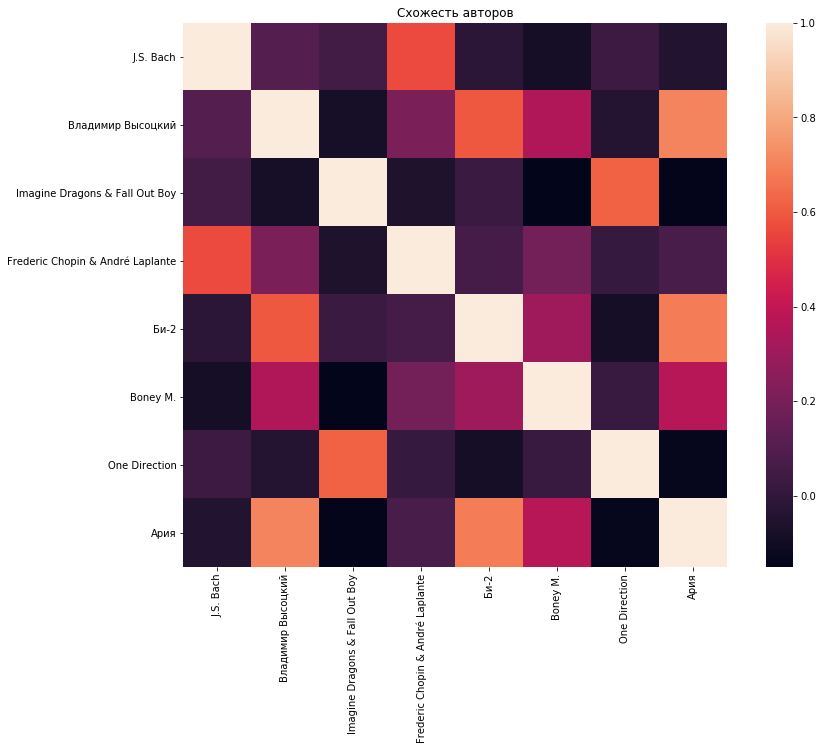

In [277]:
plt.figure(figsize=(14, 10))
sns.heatmap(np.dot(artists_embedded, np.transpose(artists_embedded, [1, 0])),
            xticklabels=artists_names,
            yticklabels=artists_names,
            square=True
           )
plt.title('Схожесть авторов')
plt.savefig('artists_heatmap.png')
plt.show()

<a id='indexing'></a>

## Indexing
Создадим поисковый индекс, который будет выдавать ближайшие вектора к данному

In [260]:
index = faiss.IndexFlatL2(EMBEDDING_SIZE)
index.add(emb_weights)

<a id='recommendation'></a>

## Recommendation

Посмотрим какие рекомендации мы получим для таких исполнителей как: `Ария`, `One Direction`, `J.S. Bach`

In [271]:
def get_recommendations(artist, num=20):
    artist = old_to_new_artist([artist])

    recommends = []
    D, I = index.search(emb_weights[artist, :], num+1)
    for idx in artist_encoder.inverse_transform(I[0])[1:]:
        recommends.append(get_artist_name(idx, persons_df))
    
    return recommends

**Ария**

In [272]:
artist = find_artist('Ария', persons_df)
print(artist)

Ария 89928
Ария 89928
Ария 89928
[89928]


In [273]:
print(*get_recommendations(89928) ,sep='\n')

Алиса
Гражданская Оборона
Владимир Высоцкий
Би-2
Аквариум  & Дживан Гаспарян
DDT
Алла Пугачева & София Ротару
5'nizza
Агата Кристи
Cause For Effect
Баста
Пранкота
Король и шут
Земфира & Billy's band & Esthetic Education
Blackmores Night
Кино
Bathory
Manowar
Дельфин (Dolphin)
Элизиум


Видим исполнителей, чьи названия написаны на русском и знакомы нам, это хороший знак того, что векторы относительно языков собраны нормально и отделяются.

**One Direction**

In [262]:
artist = find_artist('Direction', persons_df)
print(artist)

Hardwell & Joey Dale 427612
One Direction 260323
[260323, 427612]


In [274]:
print(*get_recommendations(260323) ,sep='\n')

Fall Out Boy
Imagine Dragons & Fall Out Boy
OneRepublic & Alesso
Paramore
Jason Derulo
Iggy Azalea feat. Rita Ora
Glee Cast
The Cranberries
Simple Plan
Passenger Official
Backstreet Boys
Twit
Wale
Michael W. Smith
Christina Aguilera feat. CeeLo Green
The Economist
Tiësto & Firebeatz feat. Ladyhawke
TBS RADIO 954kHz
Boyce Avenue & Tiffany Alvord acoustic cover
Catherine Coulter


Топ-15 артистов я когда-либо слышал, что тоже хорошо и стиль у этих артистов похожий

**J.S. Bach**

In [275]:
artist = find_artist('Bach', persons_df)
print(artist)

J.S. Bach 37589
J.S. Bach 37589
J.S. Bach 37589
Medeski Martin and Wood 225577
Luciano Pavarotti & Sting 208250
J.S. Bach 37589
Neil Young 248009
J.S. Bach 37589
エルヴィス・コステロ & ザ・ルーツ 124041
J.S. Bach 37589
Dionne Warwick 114529
J.S. Bach 37589
J.S. Bach 37589
[114529, 124041, 225577, 248009, 37589, 208250]


In [276]:
print(*get_recommendations(37589) ,sep='\n')

Nikolaus Harnoncourt & Zürich Opera Orchestra
Gabriel Fauré & Oxford Camerata
Giacomo Puccini
Maria Callas
Jordi Savall & Hespèrion XX
Giuseppe Verdi
Georg Philipp Telemann
Chopin (Angela Hewitt)
Sviatoslav Richter & Wiener Symphoniker & Herbert von Karajan
Vladimir Horowitz & Sergei Rachmaninoff
Frederic Chopin & André Laplante
Michael Nyman
Luigi Boccherini
Vladimir Ashkenazy [Piano]
TKKG
Dmitri Shostakovich
Catherine Coulter
Amanda Quick
MarthaDebayle
TBS RADIO 954kHz


В классической музыке я не разбираюсь, но Рахманинов, Шостакович и Шопен их этой сферы тоже на слуху у многих.

<a id='metric_eval'></a>

## Metric evaluation

In [192]:
summ = 0

for playlist in tqdm_notebook(playlists_df['new_artists_ids']):
    playlist = list(set(playlist))
    summ += metric(playlist, index, emb_weights, k=5)

print(summ / len(playlists_df))


0.016399993050851193


<a id='conclusion'></a>

## Conclusion

Подводя итоги можно сказать, что метод построеня векторного представления артистов, основанный на CBOW/skip-gram методах показал себя довольно хорошо, даже визуально очевидно качество такого представления.

У модели есть потенциал для обучения, есть еще несколько методов генерации тренировочных данных для такого рода природы данных.

Также не были использованы данные из фацлов с тегами, действиями и пользователями. Их тоже можно добавить для повышения качества модели.
